# HLS & ERA5-Land Data Extraction at Water Quality Observations

> Description
- This code is for extracting HLS bands and ERA5 Land data for each basin  
  using QA band (quality flag for water) and Density-based spatial clustering of applications with noise (DBSCAN).

- This code is a basic implementation for a specific, single-day period.  
  (A separate parallel processing code has been implemented for the entire data period.)
  
- The dates are based on HLS data.  
  (In the case of South Korea, HLS observation times are around 2 AM UTC. Accordingly, ERA5-Land data for the corresponding 2 AM UTC timestamp was extracted.)

## 1. Basic Settings

### 1.1. Import Libraries

In [ ]:
# Import libraries
import os
import sys
import platform
import importlib
import pyproj
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import geopandas as gpd
from netCDF4 import Dataset
import rasterio
from rasterio.transform import rowcol
from scipy.spatial import cKDTree
from sklearn.cluster import DBSCAN

# Set base directory
if platform.system() == 'Darwin':  # macOS
    base_FP = '/Users/lsj'
    cpuserver_data_FP = base_FP + '/cpuserver_data'
    nas_data_FP = '/Volumes/qnap_nas'
elif platform.system() == 'Linux':  # Linux systems (Workstation / CPU Server GPU Server)
    base_FP = '/home/seongjun'
    cpuserver_data_FP = base_FP + '/cpuserver_data' # Workstation / GPU Server
    if not os.path.exists(cpuserver_data_FP):
        cpuserver_data_FP = '/data' # CPU Server
    nas_data_FP = base_FP + '/NAS'

# Add Python modules path
sys.path.append(os.path.join(base_FP, 'python_modules'))

# Private modules
import HydroAI.Data as Data
import remote_sensing.HLS as HLS
import Slack.slack_notifier as Slack
importlib.reload(Data);
importlib.reload(HLS);
importlib.reload(Slack);

# Slack
env_path = os.path.join(base_FP, '.env')
notipy = Slack.Notifier(env_path)

### 1.2. Define Product and paths

In [2]:
# Define product
product = 'S30'
band_list = ['blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'qa']

# Define paths
obs_df_path = os.path.join(nas_data_FP, f'water_quality/WEIS_data/WEIS_obs_filtered_2013_2024.csv')
obs_geojson_path = os.path.join(nas_data_FP, f'water_quality/DBSCAN/obs_water_clusters.json')
pekel_file_path = os.path.join(cpuserver_data_FP, 'Pekel/Korea/water_occurrence_Korea.tif')
hls_dir_path = os.path.join(nas_data_FP, f'HLS/Korea/{product}')
era5_dir_path = os.path.join(cpuserver_data_FP, 'ERA5_Land/Korea')
save_dir_path = os.path.join(nas_data_FP, f'water_quality/HLS_ERA5_Land_test')
os.makedirs(save_dir_path, exist_ok=True)
save_path = os.path.join(save_dir_path, f'{product}')

# Get date list
date_list = sorted([dir for dir in os.listdir(hls_dir_path) if dir.isdigit() and len(dir) == 8])

# Create save directory
if not os.path.exists(save_path):
    os.makedirs(save_path, exist_ok=True)

print(f"Number of {product} dates: {len(date_list)}")

Number of S30 dates: 1115


## 2. Load Datasets 

### 2.1. In-Situ Data (Water Qaulity Observations)

In [3]:
obs_df = pd.read_csv(obs_df_path)
required_columns = ['latitude', 'longitude', 'wmcymd']
if all(col in obs_df.columns for col in required_columns):
    obs_df.rename(columns={'latitude': 'obs_lat', 'longitude': 'obs_lon', 'wmcymd': 'obs_date'}, inplace=True)
obs_df

,ptNo,ptNm,obs_lat,obs_lon,obs_date,wmdep,itemTemp,itemCloa,itemTn,itemTp,itemDoc
0,1001A05,송천1,37.658611,128.676389,3/21/13,NaN,2.5,1.5,3.785,0.020,10.5
1,1001A05,송천1,37.658611,128.676389,4/4/13,NaN,10.7,2.8,3.342,0.023,12.6
2,1001A05,송천1,37.658611,128.676389,5/29/13,NaN,17.8,5.5,2.748,0.026,10.2
3,1001A05,송천1,37.658611,128.676389,6/25/13,NaN,23.4,10.3,5.049,0.135,9.4
4,1001A05,송천1,37.658611,128.676389,7/4/13,NaN,20.6,3.9,4.419,0.045,9.7
...,...,...,...,...,...,...,...,...,...,...,...
244879,5303D70,수락저수지,34.846111,126.265000,10/23/23,NaN,19.2,16.1,0.695,0.029,7.5
244880,5303D70,수락저수지,34.846111,126.265000,6/18/24,NaN,26.2,4.4,0.304,0.010,9.5
244881,5303D70,수락저수지,34.846111,126.265000,8/6/24,NaN,31.7,10.5,0.558,0.014,10.1
244882,5303D70,수락저수지,34.846111,126.265000,9/6/24,NaN,30.0,6.8,0.270,0.014,8.8


## 3. Extract HLS and ERA5 Land data for each date

> Warning !
* This code assumes that all HLS bands have the **same shape**.
* If the HLS bands have different shapes, you need to adjust the code accordingly.
* Please check the shape of the HLS bands before running the code.

In [ ]:
# Test for specific date
date = date_list[-1]
print(date)

20241229


### 3.1. HLS

In [ ]:
# 1. Temporal filtering
# 1.1. Integrate date type
obs_df_filtered = obs_df.copy()
obs_df_filtered['obs_date'] = pd.to_datetime(obs_df_filtered['obs_date'], format='%m/%d/%y')
hls_pd_date = pd.to_datetime(date, format='%Y%m%d')

# 1.2. Temporal filtering (1 day window)
time_window = timedelta(days=1)
date_mask = (obs_df_filtered['obs_date'] >= hls_pd_date - time_window) & \
            (obs_df_filtered['obs_date'] <= hls_pd_date + time_window)

obs_df_filtered = obs_df_filtered[date_mask].copy()

# 2. HLS pre-processing
# 2.1 Read HLS data
hls_path = os.path.join(hls_dir_path, date)
HLS_reader = HLS.BandReader(hls_path, product, date)
_, transform, _ = HLS_reader.get_band_with_transform(band_list[0], product)  # Get for the first band (load transform)

# 2.2. Read entire HLS bands
NO_DATA_VALUE = -0.9999 # (-9999 * scale factor)
band_data = {}
for band in band_list:
    band_data[band] = getattr(HLS_reader, band)
    band_data[band][band_data[band] == NO_DATA_VALUE] = np.nan

# 3. Masking noisy pixels
# 3.1. Create a noise mask from QA band
# QA band bit number:
# 0 = Cirrus
# 1 = Cloud
# 2 = Adjacent to cloud/shadow
# 3 = Cloud shadow
# 4 = Snow/ice
# 5 = Water
# 6-7 = aerosol optical thickness (AOT) level

# 96 (01100000) = Water, low confidence
# 160 (10100000) = Water, medium confidence
# 224 (11100000) = Water, high confidence
# We create a 'noise_mask' that is True for everything EXCEPT water.

water_mask = np.isin(band_data['qa'], [96, 160, 224])
noise_mask = ~np.isin(band_data['qa'], [96, 160, 224])

# 3.2. Apply the mask to all bands
# This sets the noisy pixels in all bands to NaN (Not a Number)
for band in band_list:
    if band == 'qa': # Skip QA band (integer)
        continue
    band_data[band] = band_data[band].astype(np.float32) # Convert to float to allow NaN
    band_data[band][noise_mask] = np.nan

# 3.3. Clip negative values to 0 for all bands
# This ensures all pixel values are non-negative
for band in band_list:
    if band != 'qa':
        band_data[band] = np.clip(band_data[band], 0, None)

# 4. Filter observation points based on the QA mask
# 4.1. Get all observation coordinates from the DataFrame
lons = obs_df_filtered['obs_lon'].values
lats = obs_df_filtered['obs_lat'].values

# 4.2. Convert all geographic coordinates to pixel coordinates (row, col) at once
rows, cols = rowcol(transform, lons, lats)
rows, cols = np.array(rows), np.array(cols)

# 4.3. Create a mask to filter out points that are outside the image boundaries
max_row, max_col = band_data['green'].shape
valid_coords_mask = (rows >= 0) & (rows < max_row) & (cols >= 0) & (cols < max_col)

# 4.4. Filter out points that are outside the image boundaries
is_water_at_point = np.zeros(len(obs_df_filtered), dtype=bool)
valid_rows = rows[valid_coords_mask]
valid_cols = cols[valid_coords_mask]

is_water_values = ~np.isnan(band_data['green'][valid_rows, valid_cols])
is_water_at_point[valid_coords_mask] = is_water_values

final_df = obs_df_filtered[is_water_at_point].reset_index(drop=True)
final_df

,ptNo,ptNm,obs_lat,obs_lon,obs_date,wmdep,itemTemp,itemCloa,itemTn,itemTp,itemDoc
0,1003A05,영월2,37.160278,128.495833,2024-12-30,NaN,0.9,0.6,4.033,0.010,15.4
1,1003A74,충주댐,37.000833,127.996389,2024-12-30,NaN,9.7,1.3,2.368,0.018,10.7
2,1003B40,충주댐1,37.000833,127.996389,2024-12-30,68.0,9.9,1.1,2.405,0.017,10.7


In [6]:
# 5. DBSCAN Clustering
# 5.1. Set DBSCAN Hyperparameter
eps = 0.00045
EPS_RAD = np.radians(eps)
MIN_SAMPLES = 5
ALGORITHM = 'ball_tree'
METRIC = 'haversine'

# General parameters
DISTANCE_THRESHOLD = 300 # meters

# 5.2. Get the pixel coordinates (row, col) of all water pixels
water_pixel_indices = np.argwhere(water_mask)
rows = water_pixel_indices[:, 0]
cols = water_pixel_indices[:, 1]

# 5.3. Convert pixel coordinates to geographic coordinates (lon, lat)
water_lons, water_lats = rasterio.transform.xy(transform, rows, cols)

# 5.4. Convert to radians for Haversine distance
coords_rad = np.vstack((np.radians(water_lats), np.radians(water_lons))).T

# 5.5. Perform DBSCAN clustering
try:
    # Note: You might need to adjust EPS and MIN_SAMPLES for this new approach
    db = DBSCAN(eps=EPS_RAD, min_samples=MIN_SAMPLES, algorithm=ALGORITHM, metric=METRIC, n_jobs=-1).fit(coords_rad)
    water_labels = db.labels_

    print(f"Found {len(set(water_labels)) - 1} distinct water body clusters in the image.")

    notipy.send_success()

except Exception as e:
    notipy.send_error(e)
    print(e)

Found 102436 distinct water body clusters in the image.


In [7]:
# 6. Create a GeoDataFrame for all clustered water pixels
water_gdf = gpd.GeoDataFrame({
    'cluster_label': water_labels,
    'geometry': gpd.points_from_xy(water_lons, water_lats)
}, crs="EPSG:4326")

water_gdf = water_gdf[water_gdf['cluster_label'] != -1]

# 7. Create a GeoDataFrame for the observation stations from final_df
stations_gdf = gpd.GeoDataFrame(
    final_df,
    geometry=gpd.points_from_xy(final_df['obs_lon'], final_df['obs_lat']),
    crs="EPSG:4326"
)

# 7.1. Define the projected CRS for Korea (in meters)
PROJECTED_CRS = "EPSG:5186" # UTM-K

# 7.2. Re-project both GeoDataFrames to the projected CRS
stations_gdf_proj = stations_gdf.to_crs(PROJECTED_CRS)
water_gdf_proj = water_gdf.to_crs(PROJECTED_CRS)

# 7.3. Use sjoin_nearest on the re-projected data
# Now, 'max_distance' can be set directly in meters.
final_matchup_gdf_proj = gpd.sjoin_nearest(
    stations_gdf_proj,
    water_gdf_proj,
    how='left',
    max_distance=DISTANCE_THRESHOLD # Use the meter-based threshold directly
)

# 7.4. Convert the result back to the original CRS (WGS84) for consistency
final_matchup_gdf = final_matchup_gdf_proj.to_crs(stations_gdf.crs)

# 7.5. Insert HLS date
final_matchup_gdf['hls_date'] = pd.to_datetime(date, format='%Y%m%d')
final_matchup_gdf.insert(5, 'hls_date', final_matchup_gdf.pop('hls_date'))

# 7.6. Drop the extra index column created by the join
final_matchup_gdf = final_matchup_gdf.drop(columns=['index_right'])

In [8]:
final_matchup_gdf

,ptNo,ptNm,obs_lat,obs_lon,obs_date,hls_date,wmdep,itemTemp,itemCloa,itemTn,itemTp,itemDoc,geometry,cluster_label
0,1003A05,영월2,37.160278,128.495833,2024-12-30,2024-12-29,NaN,0.9,0.6,4.033,0.010,15.4,POINT (128.49583 37.16028),27545
1,1003A74,충주댐,37.000833,127.996389,2024-12-30,2024-12-29,NaN,9.7,1.3,2.368,0.018,10.7,POINT (127.99639 37.00083),31957
2,1003B40,충주댐1,37.000833,127.996389,2024-12-30,2024-12-29,68.0,9.9,1.1,2.405,0.017,10.7,POINT (127.99639 37.00083),31957


In [9]:
# 8. Extract band values for all water pixels
# 8.1. Convert longitude/latitude to pixel coordinates (row, col)
water_lons = water_gdf.geometry.x
water_lats = water_gdf.geometry.y
rows, cols = rasterio.transform.rowcol(transform, water_lons, water_lats)

# 8.2. Add pixel values of each band to water_gdf as new columns
for band in band_list:
    if band != 'qa':
        water_gdf[band] = band_data[band][rows, cols]

# 9. Calculate statistics for each cluster
# 9.1. Define the statistics to calculate
# Example: {'green': ['median', 'std'], 'red': ['median', 'std'], ...}
aggregations = {band: ['mean', 'median', 'std'] for band in band_list if band != 'qa'}

# 9.2. Calculate statistics for each cluster
cluster_stats = water_gdf.groupby('cluster_label').agg(aggregations)

# 10. Change the column names of the calculated statistics
# Example: ('green', 'median') -> 'green', ('green', 'std') -> 'green_std'
new_columns = []
for band, stat in cluster_stats.columns:
    new_columns.append(f"{band}_{stat}")
cluster_stats.columns = new_columns

# 11. Merge statistics into final_matchup_gdf
# 11.1. Merge on 'cluster_label'
obs_hls_df = pd.merge(
    final_matchup_gdf,
    cluster_stats,
    on='cluster_label',
    how='left' # Keep all rows from final_matchup_gdf
)

obs_hls_df

,ptNo,ptNm,obs_lat,obs_lon,obs_date,hls_date,wmdep,itemTemp,itemCloa,itemTn,...,red_std,nir_mean,nir_median,nir_std,swir1_mean,swir1_median,swir1_std,swir2_mean,swir2_median,swir2_std
0,1003A05,영월2,37.160278,128.495833,2024-12-30,2024-12-29,NaN,0.9,0.6,4.033,...,0.016844,0.026281,0.0189,0.024154,0.030524,0.0189,0.028672,0.022379,0.0133,0.021393
1,1003A74,충주댐,37.000833,127.996389,2024-12-30,2024-12-29,NaN,9.7,1.3,2.368,...,0.011918,0.012031,0.0018,0.021495,0.014858,0.0041,0.025731,0.010877,0.0036,0.018166
2,1003B40,충주댐1,37.000833,127.996389,2024-12-30,2024-12-29,68.0,9.9,1.1,2.405,...,0.011918,0.012031,0.0018,0.021495,0.014858,0.0041,0.025731,0.010877,0.0036,0.018166


In [10]:
# 12. Calculate satellite-based indices
final_obs_hls_df = obs_hls_df.copy()

with np.errstate(divide='ignore', invalid='ignore'):
    # 1) NDWI
    final_obs_hls_df['NDWI'] = (final_obs_hls_df['nir_mean'] - final_obs_hls_df['swir1_mean']) / (final_obs_hls_df['nir_mean'] + final_obs_hls_df['swir1_mean'])
    # 2) MNDWI
    final_obs_hls_df['MNDWI'] = (final_obs_hls_df['green_mean'] - final_obs_hls_df['swir1_mean']) / (final_obs_hls_df['green_mean'] + final_obs_hls_df['swir1_mean'])
    # 3) NDVI (for water)
    final_obs_hls_df['NDVI'] = (final_obs_hls_df['nir_mean'] - final_obs_hls_df['red_mean']) / (final_obs_hls_df['nir_mean'] + final_obs_hls_df['red_mean'])
    # 4) Blue-Green Ratio
    final_obs_hls_df['Green_Blue_Ratio'] = final_obs_hls_df['green_mean'] / final_obs_hls_df['blue_mean']
    # 5) NIR-Red Ratio
    final_obs_hls_df['NIR_Red_Ratio'] = final_obs_hls_df['nir_mean'] / final_obs_hls_df['red_mean']


# Replace inf and -inf with NaN
final_obs_hls_df.replace([np.inf, -np.inf], np.nan, inplace=True)
final_obs_hls_df

,ptNo,ptNm,obs_lat,obs_lon,obs_date,hls_date,wmdep,itemTemp,itemCloa,itemTn,...,swir1_median,swir1_std,swir2_mean,swir2_median,swir2_std,NDWI,MNDWI,NDVI,Green_Blue_Ratio,NIR_Red_Ratio
0,1003A05,영월2,37.160278,128.495833,2024-12-30,2024-12-29,NaN,0.9,0.6,4.033,...,0.0189,0.028672,0.022379,0.0133,0.021393,-0.074702,-0.233998,0.200171,1.169196,1.500536
1,1003A74,충주댐,37.000833,127.996389,2024-12-30,2024-12-29,NaN,9.7,1.3,2.368,...,0.0041,0.025731,0.010877,0.0036,0.018166,-0.105121,-0.133138,0.319024,1.263485,1.936961
2,1003B40,충주댐1,37.000833,127.996389,2024-12-30,2024-12-29,68.0,9.9,1.1,2.405,...,0.0041,0.025731,0.010877,0.0036,0.018166,-0.105121,-0.133138,0.319024,1.263485,1.936961


### 3.2. ERA5-Land

In [ ]:
# =============================================================================#
# ERA5-Land Data
# =============================================================================#
# 1. Load ERA5 grid coordinates and data
year = date[:4]
era5_path = os.path.join(era5_dir_path, f'{year}/ERA5_land_{date}.nc')
ds = Dataset(era5_path, 'r')

# WGS84 (EPSG:4326) -> UTM-K (EPSG:5186)
transformer = pyproj.Transformer.from_crs("EPSG:4326", "EPSG:5186", always_xy=True)

lon_era5 = ds.variables['longitude'][:]
lat_era5 = ds.variables['latitude'][:]
lon_2d, lat_2d = np.meshgrid(lon_era5, lat_era5)

# Convert ERA5 grid coordinates to UTM-K (EPSG:5186)
era5_x, era5_y = transformer.transform(lon_2d.ravel(), lat_2d.ravel())
grid_points_proj = np.vstack([era5_x, era5_y]).T
era5_tree = cKDTree(grid_points_proj)

# Convert observation coordinates to UTM-K (EPSG:5186)
station_lon = final_obs_hls_df['obs_lon'].values
station_lat = final_obs_hls_df['obs_lat'].values
station_x, station_y = transformer.transform(station_lon, station_lat)
station_points_proj = np.vstack([station_x, station_y]).T

# Find the index of the closest ERA5 grid point for each observation
distances, indices = era5_tree.query(station_points_proj, k=1)
lat_indices, lon_indices = np.unravel_index(indices, lon_2d.shape)

# 3. Pre-process precipitation data (tp)
# 3.1. Calculate the date for the day before the target date
target_date_dt = datetime.strptime(date, '%Y%m%d')
era5_path_1 = os.path.join(era5_dir_path, f'{year}/ERA5_land_{(target_date_dt - timedelta(days=1)).strftime("%Y%m%d")}.nc')
era5_path_2 = os.path.join(era5_dir_path, f'{year}/ERA5_land_{(target_date_dt - timedelta(days=2)).strftime("%Y%m%d")}.nc')

# 3.2. Load the data for the previous days
with Dataset(era5_path_1, 'r') as ds1:
    tp_day_1 = ds1.variables['tp'][:]
with Dataset(era5_path_2, 'r') as ds2:
    tp_day_2 = ds2.variables['tp'][:]

tp_day_0 = ds.variables['tp'][:]

# 3.3. Calculate the cumulative precipitation and add it to final_obs_hls_df
tp_24hr = np.sum(tp_day_0[:, lat_indices, lon_indices], axis=0)
tp_48hr = tp_24hr + np.sum(tp_day_1[:, lat_indices, lon_indices], axis=0)
tp_72hr = tp_48hr + np.sum(tp_day_2[:, lat_indices, lon_indices], axis=0)

final_obs_hls_df['tp_24h'] = tp_24hr
final_obs_hls_df['tp_48h'] = tp_48hr
final_obs_hls_df['tp_72h'] = tp_72hr

# 4. Pre-process other variables
exclude_vars = {"number", "valid_time", "expver", "latitude", "longitude",
                "stl2", "stl3", "stl4", "asn", "snowc", "rsn", "lict",
                "sde", "sd", "swvl2", "swvl3", "swvl4", "ssrd", "strd", 'lai_hv', 'lai_lv'}

for var_name in ds.variables:
    if var_name not in exclude_vars and var_name in ds.variables:
        # Calculate the daily mean value
        var_data = ds.variables[var_name][:]
        values = var_data[2, lat_indices, lon_indices]
        final_obs_hls_df[var_name] = values

ds.close()

### 3.3. Results

In [12]:
final_obs_hls_df

,ptNo,ptNm,obs_lat,obs_lon,obs_date,hls_date,wmdep,itemTemp,itemCloa,itemTn,...,pev,ro,es,ssro,sro,e,u10,v10,sp,tp
0,1003A05,영월2,37.160278,128.495833,2024-12-30,2024-12-29,NaN,0.9,0.6,4.033,...,-0.000246,0.000064,-0.000007,0.000062,0.000002,-0.000013,2.085449,0.029053,97445.9375,0.0
1,1003A74,충주댐,37.000833,127.996389,2024-12-30,2024-12-29,NaN,9.7,1.3,2.368,...,-0.000152,0.000079,-0.000002,0.000077,0.000002,-0.000011,1.578613,0.138428,100349.9375,0.0
2,1003B40,충주댐1,37.000833,127.996389,2024-12-30,2024-12-29,68.0,9.9,1.1,2.405,...,-0.000152,0.000079,-0.000002,0.000077,0.000002,-0.000011,1.578613,0.138428,100349.9375,0.0


## Visualization

In [13]:
def plot_final_map(matchup_gdf, all_clusters_gdf, pt_no_to_plot, pekel_file_path, plot_radius_m=1500, padding=0.001):
    """
    Plot clustering result on water occurrence map in selected station
    """
    import numpy as np
    import pandas as pd
    import geopandas as gpd

    import rasterio
    import pyproj
    from rasterio.windows import from_bounds
    from rasterio.warp import reproject, Resampling, calculate_default_transform
    from shapely.geometry import Point

    import matplotlib.pyplot as plt
    import matplotlib.patches as mpatches
    from matplotlib.ticker import FormatStrFormatter
    from mpl_toolkits.axes_grid1 import make_axes_locatable

    # =============================================================================#
    # Calculate the bounds of the plot
    # =============================================================================#

    # Check if the station is in the matchup data
    station_info_row = matchup_gdf[matchup_gdf['ptNo'] == pt_no_to_plot]
    if station_info_row.empty:
        print(f"Station {pt_no_to_plot} not found in matchup data")
        return

    station_info = station_info_row.iloc[0]
    station_lat, station_lon = station_info.geometry.y, station_info.geometry.x

    # Calculate the center of the plot using pyproj
    transformer = pyproj.Transformer.from_crs("EPSG:4326", "EPSG:5186", always_xy=True)
    center_x, center_y = transformer.transform(station_lon, station_lat)

    # Calculate the bounds of the plot (meters)
    north_point = Point(center_x, center_y + plot_radius_m)
    south_point = Point(center_x, center_y - plot_radius_m)
    east_point = Point(center_x + plot_radius_m, center_y)
    west_point = Point(center_x - plot_radius_m, center_y)

    # Convert UTM-K to WGS84
    transformer_reverse = pyproj.Transformer.from_crs("EPSG:5186", "EPSG:4326", always_xy=True)

    _, north_lat = transformer_reverse.transform(north_point.x, north_point.y)
    _, south_lat = transformer_reverse.transform(south_point.x, south_point.y)
    east_lon, _ = transformer_reverse.transform(east_point.x, east_point.y)
    west_lon, _ = transformer_reverse.transform(west_point.x, west_point.y)

    bounds = (
        min(west_lon, east_lon),  # left
        min(south_lat, north_lat),  # bottom
        max(west_lon, east_lon),  # right
        max(south_lat, north_lat)   # top
    )

    # =============================================================================#
    # Background Pekel Water Occurrence Map
    # =============================================================================#

    # Read the Pekel raster file
    try:
        with rasterio.open(pekel_file_path) as src:
            # Convert the raster coordinate system to WGS84 if it is not already
            if src.crs != 'EPSG:4326':
                from rasterio.warp import reproject, Resampling, calculate_default_transform

                dst_crs = 'EPSG:4326'
                transform, width, height = calculate_default_transform(
                    src.crs, dst_crs, src.width, src.height, *src.bounds)

                # Save the reprojected raster to memory
                reprojected_data = np.empty((height, width), dtype=src.dtypes[0])
                reproject(
                    source=src.read(1),
                    destination=reprojected_data,
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.nearest
                )
            else:
                # If the raster is already in WGS84
                reprojected_data = src.read(1)
                transform = src.transform

        # Extract the raster part corresponding to the ROI
        left, bottom, right, top = bounds
        window = from_bounds(left, bottom, right, top, transform)

        # Check if the window is valid and extract the raster data
        if (window.row_off >= 0 and window.col_off >= 0 and
            window.row_off + window.height <= reprojected_data.shape[0] and
            window.col_off + window.width <= reprojected_data.shape[1]):

            # Extract the raster data
            raster_slice = reprojected_data[
                int(window.row_off):int(window.row_off + window.height),
                int(window.col_off):int(window.col_off + window.width)
            ]

            # Check if the data is all zeros
            if np.all(raster_slice == 0):
                print("Warning: Extracted raster data is all zeros")
                raster_slice = np.zeros((100, 100), dtype=reprojected_data.dtype)
        else:
            raster_slice = np.zeros((100, 100), dtype=reprojected_data.dtype)

    except Exception as e:
        print(f"Error reading raster file: {e}")
        raster_slice = np.zeros((100, 100))

    # =============================================================================#
    # Plotting
    # =============================================================================#

    # Create a figure and axis
    _, ax = plt.subplots(1, 1, figsize=(12, 12))
    ax.set_aspect('equal', adjustable='box')

    # Display the Pekel raster as background
    if raster_slice.size > 0 and not np.all(raster_slice == 0):
        # Display the raster as an image
        im = ax.imshow(raster_slice, extent=[left, right, bottom, top], cmap='Blues', alpha=0.7, zorder=1)

        # Colorbar
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0) # Create a new axis on the right with 5% size
        cbar = plt.colorbar(im, cax=cax)
        cbar.set_label('Water Occurrence (%)', fontsize=12, labelpad=10)

    # Display the clustering result
    if pd.notna(station_info['cluster_label']):
        target_cluster_gdf = all_clusters_gdf[all_clusters_gdf['cluster_label'] == station_info['cluster_label']]
        if not target_cluster_gdf.empty:
            target_cluster_gdf.plot(ax=ax, color='gold', markersize=10, zorder=2)
        else:
            print("No cluster points found for this station")
    else:
        print("No cluster label found for this station")

    # Display the observation station
    station_point = gpd.GeoSeries([Point(station_lon, station_lat)], crs="EPSG:4326")
    station_point.plot(ax=ax, marker='*', color='red', markersize=300, edgecolor='black', zorder=3)

    # Set the limits of the plot
    ax.set_xlim(bounds[0], bounds[2])
    ax.set_ylim(bounds[1], bounds[3])

    # Legend and other settings
    ax.set_title(f"Clustered Water Pixels for WQ Station: ({pt_no_to_plot})", fontsize=16, fontweight='bold', pad=10)
    ax.set_xlabel("Longitude", fontsize=14, labelpad=10)
    ax.set_ylabel("Latitude", fontsize=14, labelpad=10)
    ax.tick_params(axis='both', labelsize=12)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))

    # Create legend handles manually
    handles = [
        plt.Line2D([0], [0], marker='o', color='w', label='Clustered Water Pixels', markerfacecolor='gold', markersize=8),
        plt.Line2D([0], [0], marker='*', color='w', label='WQ Station', markerfacecolor='red', markeredgecolor='black', markersize=18),
        mpatches.Patch(color='steelblue', alpha=0.7, label='Water Occurrence (%)')
    ]
    ax.legend(handles=handles, loc='upper right', fontsize=10)

    plt.show()

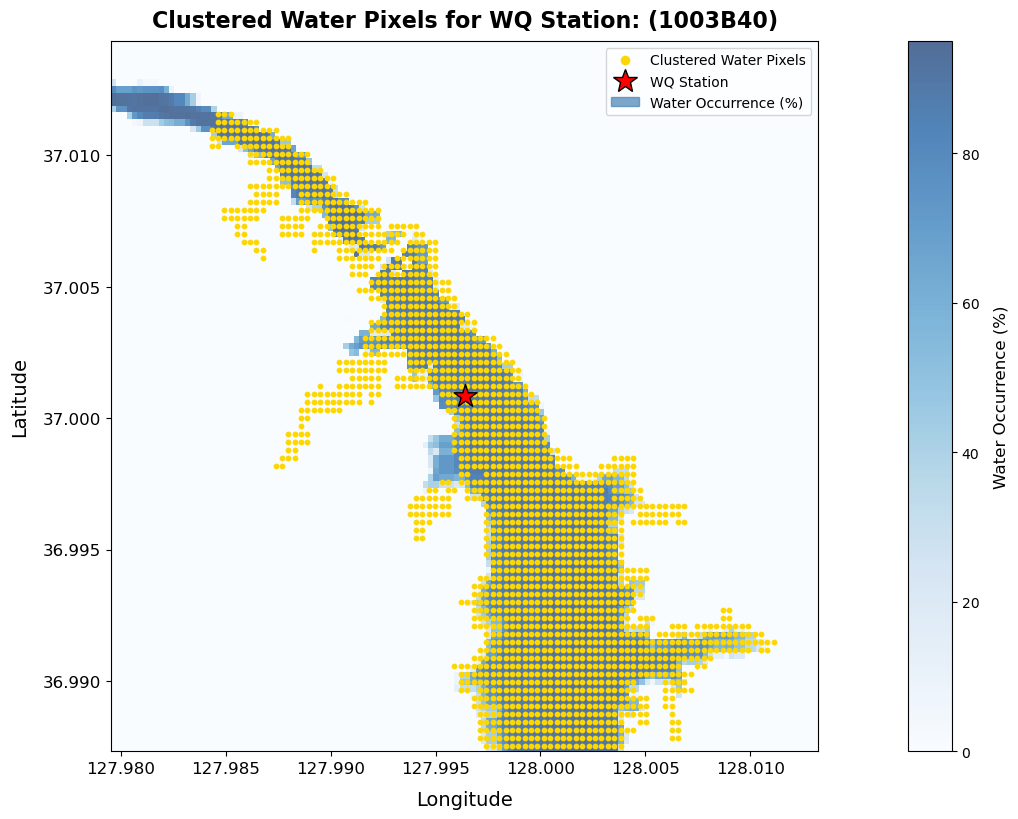

In [14]:
# Define the target station ID
target_station_id = '1003B40'

# Visualization
plot_final_map(
    matchup_gdf=final_matchup_gdf,
    all_clusters_gdf=water_gdf,
    pt_no_to_plot=target_station_id,
    pekel_file_path=pekel_file_path
)